In [1]:
%matplotlib inline
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import numpy as np
import pyrfume
from pyrfume import pubchem
import re
import requests
from tqdm.auto import tqdm

In [5]:
def update_results(records, results):
    keywords = ('odor', 'odour', 'smell', 'aroma ', 'aroma,', 'aroma.', 'fragrance')
    for annotation in records['Annotations']['Annotation']:
        try:
            cids = annotation['LinkedRecords']['CID']
        except:
            pass
        else:
            strings = [] 
            for x in annotation['Data']:
                for y in x['Value']['StringWithMarkup']:
                    strings.append(y['String'])
            for cid in cids:
                if cid in results:
                    results[cid] += strings
                elif strings:
                    results[cid] = strings

In [6]:
def get_results(heading):
    page = 1
    results = {}
    with tqdm(total=100) as pbar:
        while True:
            url = (f"https://pubchem.ncbi.nlm.nih.gov/rest/pug_view/annotations/heading/"
                   f"JSON?heading_type=Compound&heading={heading}&page={page}")
            response = requests.get(url)
            records = response.json()
            update_results(records, results)
            totalPages = records['Annotations']['TotalPages']
            if page==1:
                pbar.reset(total=totalPages)
            pbar.set_description("%d CIDs described" % len(results))
            pbar.update()
            page += 1
            if page > totalPages:
                break
    return results

In [7]:
pd_results = get_results("Vapor+Pressure")

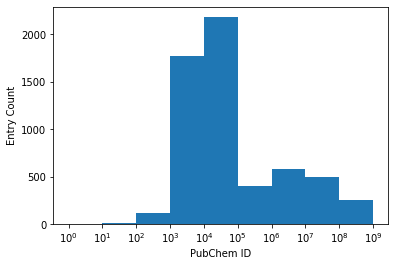

In [8]:
def make_hist(results):
    plt.hist(np.log10(list(results.keys())), bins=np.arange(10));
    xticks = np.arange(10)
    plt.xticks(xticks, ['$10^%d$' % x for x in xticks]);
    plt.xlabel('PubChem ID')
    plt.ylabel('Entry Count')
    
make_hist(pd_results)

In [9]:
pd_cids = set(key for key in pd_results)
len(pd_cids)

5820

In [10]:
all_statements = {}
cids = sorted(set(pd_cids))
for cid in cids:
    ps = pd_results.get(cid, [])
    all_statements[cid] = ps
len(all_statements)

5820

In [15]:
import json
with open('pubchem-vapor-pressure.json', 'w') as f:
    json.dump(all_statements, f)